# **Variational Auto-Encoder**

For our final set of NBs, we will be wrapping up our work on unconditional stable diffusion models. To do this we will be introducing the concept of Variational Auto Encoders to generate our required latents (because Stable Diffusion is, in effect, a _Latent Diffusion_ model).

Perplexity defines VAEs as:

> Variational Autoencoders (VAEs) are a class of generative models in machine learning that combine principles from deep learning and probabilistic graphical models. Introduced by Diederik P. Kingma and Max Welling in 2013, VAEs are designed to learn complex data distributions and generate new data points that resemble the training data.
>
> ### **Architecture of VAEs**
>
> VAEs consist of two main components:
>
> **Encoder**: This neural network compresses input data into a latent representation. Instead of producing a single point in the latent space, the encoder outputs parameters for a probability distribution (typically Gaussian), which describes the latent variables. This probabilistic approach allows VAEs to capture the uncertainty in the data representation1
>
> **Decoder**: The decoder takes samples from the latent distribution and reconstructs the original input data. By sampling from the learned distribution, the decoder can generate new instances of data that are similar but not identical to the training samples.
>
> ### **How VAEs Generate Latents**
> The process of generating latents in VAEs involves several steps:
>
> **Input Data Encoding**: The encoder transforms input data into a probabilistic latent space, represented as **$q(z∣x)$**, where $z$ denotes latent variables and $x$ is the input data.
> 
> **Sampling**: From this distribution, a sample $z$ is drawn, typically using techniques like reparameterization, which allows gradients to flow through the stochastic part of the model during training.
>
> **Data Reconstruction**: The sampled latent vector $z$ is fed into the decoder, which reconstructs the input data, aiming to minimize reconstruction loss while adhering to a specified prior distribution (often a standard normal distribution).

The VAE will convert the 256x256, 3 channel images into 32x32x4 latent representations.

In [ ]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

In [1]:
import os, timm, torch, random, datasets, math, fastcore.all as fc
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.training import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 80

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus > 8: fc.defaults.cpus=8

In [3]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 256
dsd = load_dataset(name)

In [4]:
@inplace
def transformi(b):
    img = [TF.to_tensor(o).flatten() for o in b[xl]] # Flatten input pixels into a vector
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [5]:
dl = dls.valid
xb, yb = b = next(iter(dl))

## **Setting Up The AutoEncoder**

In [6]:
# Architecture for the autoencoder, featuring number of hidden (nh), number of inputs (ni) 
# and number of latent outputs i.e. 200. 
ni, nh, nl = 784, 400, 200

In [7]:
# Setup a basic linear layer
def lin(ni, nf, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act : layers.append(act())
    if norm: layers.append(norm(nf))
    return layers

In [8]:
# Update init_weights to initialize linear layers as well
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [9]:
iw = partial(init_weights, leaky=0.2)

In [10]:
# Creating a regular autoencoder
class Autoenc(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh), lin(nh, nl)) # generates latents
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None)) # latents decoded to 784 inputs
        iw(self)

    def forward(self, x):
        x = self.enc(x)
        return self.dec(x)

In [11]:
opt_func = partial(optim.Adam, eps=1e-5)

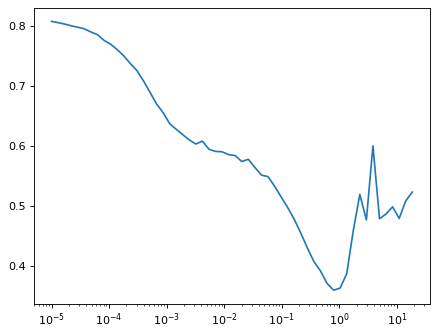

In [12]:
Learner(Autoenc(), dls, nn.BCEWithLogitsLoss(), cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

In [ ]:
#del(learn)

In [13]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = Autoenc()
learn = Learner(model, dls, nn.BCEWithLogitsLoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.528,0,train
0.468,0,eval
0.400,1,train
0.350,1,eval
0.316,2,train
0.299,2,eval
0.286,3,train
0.285,3,eval
0.276,4,train
0.276,4,eval


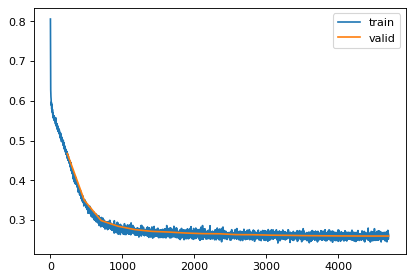

In [14]:
learn.fit(epochs)

## **Sampling From AutoEncoder**

In [18]:
with torch.no_grad(): t = to_cpu(model(xb.cuda()).float())

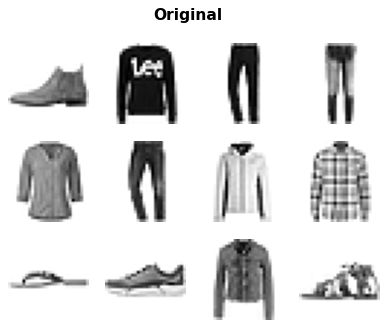

In [25]:
show_images(xb[:12].reshape(-1, 1, 28, 28), imsize=1.5, title='Original')

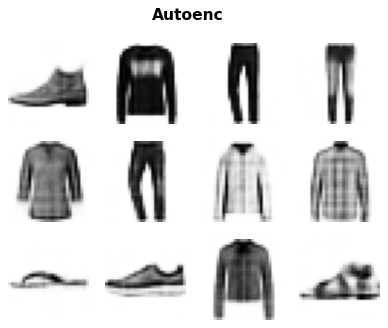

In [26]:
show_images(t[:12].reshape(-1,1,28,28).sigmoid(), imsize=1.5, title='Autoenc');

This particular AutoEncoder doesn't have to work too hard to compress the inputs given the small image sizes. Also, it does a pretty poor job of reproducing the inputs once they're decoded. 

Lets proceed with adding some noise to the encoded images, given that we already have a trained decoder.

In [21]:
# Adding noise to encoded inputs
noise = torch.randn(16, nl).cuda()
with torch.no_grad(): generated_images = model.dec(noise).sigmoid()

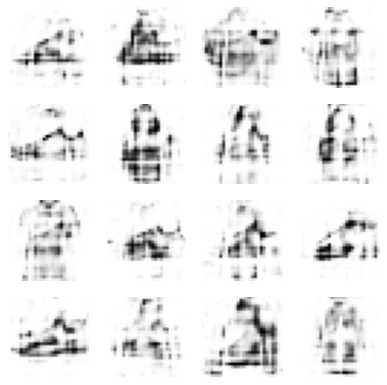

In [27]:
show_images(generated_images.reshape(-1, 1, 28, 28), imsize=1.5)

While setting up and training an AutoEncoder works for demo purposes, it certainly doesn't meet the standards for an "image generator" in 2024. In its current form, the final vector of length 200 doesn't allow for the creation of novel items of clothing based on the inputs. Adding random noise and decoding a vector of 16 items doesn't result in anything recognizable.

## **Fixing the Image Generation Problem With a VAE (Variational AutoEncoder)**

![title](imgs/The-basic-architecture-of-variational-autoencoder-VAE.png)

With the VAE the **Encoder** outputs parameters of a probability distribution, whiich is typically Gaussian and is characterized by a mean and variance. This allows the VAE to capture uncertainty in the data representation thereby allowing the generation of diverse outputs from relatively limited inputs.

The **Latent Space** serves as the bottleneck of the VAE, where each point corresponds to a distribution rather than a deterministic encoding. The VAE learns to structure the latent space such that similar inputs are mapped close together - which allows meaningful data generation during sampling. 

The **Decoder** functions the same as before. During the training process, the VAE optimizes two primary objectives:

1. **Reconstruction Loss:** Measures how well the output from the decoder matches the original input.
2. **Regularization Loss (KL - Divergence)**: Ensures that the latent distributions conform to a prior distribution (which is usually, Gaussian) to promote generalization and prevent overfitting.

In [28]:
del(learn)
clean_mem()

In [29]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh))
        # Additional encoding layers mu (mean) and lv (log variance)
        self.mu, self.lv = lin(nh, nl, act=None), lin(nh, nl, act=None) 
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None))
        iw(self)

    def forward(self, x):
        x = self.enc(x)
        # New layers are used to generate random numbers, which have a mean of mu and log variance
        # is used to calculate standard deviation using (0.5*lv).exp() * torch.randn_like(lv). 
        mu, lv = self.mu(x), self.lv(x)
        z = mu + (0.5*lv).exp()*torch.randn_like(lv) # Results in normally distributed numbers
        return self.dec(z), mu, lv

In [30]:
def kld_loss(inp, x):
    # KLD loss ensures that the log variance doesn't go to zero.
    # x_hat(reconstructed output), mu(mean of latents), lv(log variance)
    x_hat, mu, lv = inp
    #-0.5 minimizes divergence
    # (1 + lv - mu.pow(2) - lv.exp()).mean() penalizes deviations from normal distribution.
    return -0.5 * (1 + lv - mu.pow(2) - lv.exp()).mean()

def bce_loss(inp, x): return F.binary_cross_entropy_with_logits(inp[0], x) # BCE / Reconstructing loss b/w input and target

def vae_loss(inp, x): return kld_loss(inp, x) + bce_loss(inp, x)

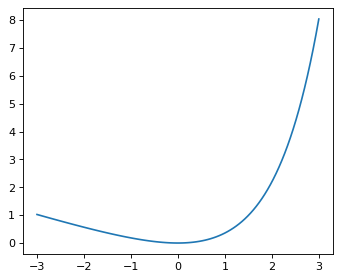

In [60]:
# Under the hood of KLD loss
# Space around the latent point of interest should also be optimized to decode back to the original
x = torch.linspace(-3, 3, 100)
plt.figure(figsize=(5, 4))
plt.plot(x, -0.5*(1 + x - x.exp()));

According to Perplexity, if the KL Divergence Loss is not properly balanced in a VAE then the following issues can arise:

> **1. Poor Latent Space Representation**
An improperly balanced KL divergence can lead to a latent space that does not effectively capture the underlying structure of the data. If the KL divergence is too low, the model may ignore the regularization effect, resulting in a latent space that is overly complex and not well-structured. Conversely, if it is too high, it can constrain the model excessively, leading to a loss of important information about the input data.
>
> **2. Mode Collapse**
When KL divergence is not balanced, the VAE may suffer from mode collapse, where it generates only a limited variety of outputs. This occurs when the model learns to encode only a few modes of the data distribution, neglecting others. In practice, this means that while some reconstructions may be accurate, others will be poorly represented or entirely missing.
>
> **3. Reconstruction Quality**
The balance between reconstruction loss and KL divergence directly affects reconstruction quality. If the KL term dominates, the model may prioritize fitting the prior distribution over accurately reconstructing inputs, resulting in blurry or unrecognizable outputs. On the other hand, if reconstruction loss dominates, the latent space may become too chaotic, leading to poor generalization and inability to generate novel samples.
> 
> **4. Training Instability**
Training instability can occur if there is an imbalance in loss components. For instance, if KL divergence initially decreases but later increases significantly during training (as noted in some training logs), it can lead to oscillations in loss values and hinder convergence. This instability can complicate hyperparameter tuning and make it challenging to achieve consistent performance.
>
> **5. Inefficient Use of Latent Variables**
Without proper balancing, some latent variables may become underutilized or overutilized. This inefficiency can result in a sub-optimal use of network capacity, where only a limited number of latent dimensions are active while others remain inactive. This can prevent the model from fully leveraging its potential to capture complex data distributions.

In [33]:
class FuncMetric(Mean): # Derived from torcheval.metrics
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn

    def update(self, inp, targets): # TorchEval call for metrics
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

In [34]:
metrics = MetricsCB(kld=FuncMetric(kld_loss), bce=FuncMetric(bce_loss)) # Print additional metrics - though approach isnt optimized
opt_func = partial(optim.Adam, eps=1e-5)

In [35]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, BatchSchedCB(sched), MixedPrecision()]
model = VAE()
learn = Learner(model, dls, vae_loss, lr=lr, cbs=cbs, opt_func=opt_func)

In [42]:
model

VAE(
  (enc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): SiLU()
      (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): SiLU()
      (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lv): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dec): Sequential(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=400, bias=True)
      (1): SiLU()
      (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


kld,bce,loss,epoch,train
0.429,0.546,0.976,0,train
0.305,0.496,0.800,0,eval
0.100,0.445,0.545,1,train
0.045,0.407,0.452,1,eval
0.034,0.383,0.416,2,train
0.037,0.362,0.399,2,eval
0.035,0.357,0.391,3,train
0.039,0.350,0.389,3,eval
0.036,0.348,0.383,4,train
0.036,0.347,0.382,4,eval


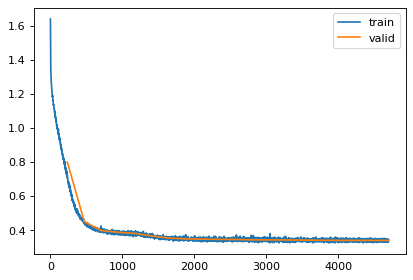

In [43]:
learn.fit(epochs)

## **Sampling From The VAE**

In [44]:
with torch.no_grad(): t, m, lv = to_cpu(model(xb.cuda()))
t = t.float()

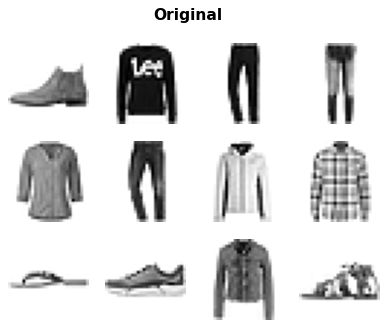

In [52]:
show_images(xb[:12].reshape(-1, 1, 28, 28), imsize=1.5, title='Original')

BCE loss being worse is indicative of a harder problem to solve for the model. It is also worse at reconstruction since patterns and logo details are also missing.

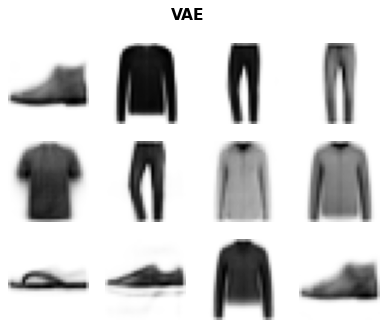

In [54]:
show_images(t[:12].reshape(-1, 1, 28, 28).sigmoid(), imsize=1.5, title='VAE')

In [55]:
# Adding noise
noise = torch.randn(16, nl).cuda()
with torch.no_grad(): ims = model.dec(noise).sigmoid()

Calling the decoder on random noise gives considerably better results than standard encoders. Also VAEs which are used primarily for generation are different than the ones used for compressions. Specifically,

> #### **Latent Space Representation**
>
>    **Generative VAEs:** In generative VAEs, the encoder outputs parameters (mean and variance) of a probability distribution (often Gaussian) for each input. This allows for smooth sampling from the latent space, enabling the generation of new, coherent data points by sampling from this distribution.
> 
>    **Compression VAEs:** For compression purposes, while the latent space may still be probabilistic, the emphasis is on maintaining fidelity in reconstructing the original input from its compressed form. The latent space might not be as regularized as in generative models, focusing more on effective encoding and decoding rather than generating new samples.
>
> #### **Training Loss Functions**
>
>    **Generative Focus:** Generative VAEs typically incorporate KL divergence in their loss functions to ensure that the learned latent distributions closely match a prior distribution (e.g., standard normal). This regularization encourages exploration of the latent space, facilitating diverse sample generation.
> 
>    **Compression Focus:** In contrast, compression-focused VAEs may prioritize reconstruction loss over KL divergence. The primary goal is to minimize the difference between the original and reconstructed inputs rather than exploring the generative capabilities of the model.

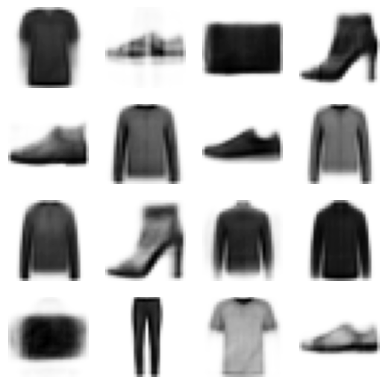

In [56]:
show_images(ims.reshape(-1, 1, 28, 28), imsize=1.5)